In [3]:
import torch
import torch.nn.functional as F
import sys
try: # whether we're on titanic or not work on my regression_classif branch at least.
    sys.path.append("/home/mathieu/local/py_script/dnadna")
    import net as net_module
except ModuleNotFoundError:
    #sys.path.append("/home/jean/Documents/ML_genetics/dnadna/")
    #import net as net_module
    print("import fail")
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def relative_position(pos):
    """
    Given an array of absolute position within [0, 1], returns an array of same
    shape with relative distance to previous position.

    The first distance is the one between first and last element.  The absolute
    position of the first element is also returned.

    Examples
    --------

    >>> from dnadna.datasets import relative_position
    >>> import numpy as np
    >>> pos = np.array([0.1, 0.3, 0.6, 0.65, 0.8])
    >>> relative_position(pos)
    (array([0.3 , 0.2 , 0.3 , 0.05, 0.15]), 0.1)
    """
    posd = np.diff(pos)
    npos = np.insert(posd, 0, (pos[0] - pos[-1])) % 1
    # Ensure that the original dtype is preserved, because the above line can
    # sometimes accidentally convert to a dtype not supported by pytorch
    return npos.astype(pos.dtype), pos[0]



In [5]:
dfparam = pd.read_csv('/media/mathieu/crucialmx300/exp/BacterialDemoSelection_param', sep="\t", header=0)

def compute_expected_class(scenario_name):
    expected_class = 1
    model_init = dfparam.at[int(scenario_name[9:]),'model_init']
    if 'Noselection' in model_init :
        expected_class = 0
    return expected_class

In [6]:
def sensitivity(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum((grp.expected_class == 1) & (grp.observed_class==1)) + sum((grp.expected_class == 1) & (grp.observed_class==0))) 

In [35]:
def specificity(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum((grp.expected_class == 0) & (grp.observed_class==0)) + sum((grp.expected_class == 0) & (grp.observed_class==1))) 

In [9]:
#Initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(2)
net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/home/mathieu/local/net/BacterialDemoSelection_run_008_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)

In [10]:
#Original data
def compute_original_data_prediction(originalDatapath):
    #initiate result dataframe
    dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                                  'observed_class', 'softmax_for_observed_class','nb_SNP'])
    
    i=0
    for scenario in os.listdir(originalDatapath):
        scenardir = originalDatapath +'/'+ scenario
        for replicate in os.listdir(scenardir):
            replicatepath = scenardir + '/' + replicate

            expected_class = compute_expected_class(scenario)

            try :
                #compute prediction
                data_snp = np.load(replicatepath)
                snp, pos = data_snp["SNP"], data_snp["POS"]
                pos = relative_position(pos)
                pos = pos[0]
                matrixLength = snp.shape[1]
                data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                output = net3(data_in)

                val, predicted_class = torch.max(output, 1)

                predicted_class_int = predicted_class.item()               
                softmax = sm(output)
                listsm = softmax.tolist()
                softmax_float = max(listsm[0])

                if predicted_class_int !=  expected_class :
                    real_softmax_float = 1 - softmax_float
                else :
                    real_softmax_float = softmax_float

                #create new line for each replicate
                dfres.loc[i] = [scenario, replicate, 0, 0, 0, expected_class , predicted_class_int, real_softmax_float, matrixLength]
                i += 1

            except RuntimeError:
                #not enough positions ?
                print("error computing prediction for " + scenario + ':' + replicate + ': nbSNP=' + str(matrixLength))
            
    return dfres

In [11]:
#After gargammel result are in different repertories
#Repertories have different names depending which parameter have been used
#This function use the name of the repertorie to extract parameters value

def translate_real_param(dirname):
    realparam = dirname.replace('_', ' ').replace('t','-')
    params = realparam.split(',')
    coverage = params[0].split(' ')[1]
    if len(params) > 1:
        sequencing_error_param = params[1].split(' ')[1]
        sequencing_error = math.ceil(0.1 * 1/(pow(10,(int(sequencing_error_param)/10))))
    else:
        sequencing_error = 0.1
    return coverage, sequencing_error

In [12]:
#damaged data
def compute_damage_data_prediction(postGargapath):
    i=0
    #initiate result dataframe
    dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                                  'observed_class', 'softmax_for_observed_class','nb_SNP'])
    
    for degree in os.listdir(postGargapath):
        degreepath = postGargapath + '/' + degree
        if os.path.isdir(degreepath) :
            for param in os.listdir(degreepath):
                coverage, sequencing_error = translate_real_param(param)
                parampath = degreepath + '/' + param        
                for scenario in os.listdir(parampath):
                    scenariopath =  parampath +'/'+ scenario
                    for replicate in os.listdir(scenariopath):
                        replicatepath = scenariopath + '/' + replicate

                        try :

                            #compute prediction
                            data_snp = np.load(replicatepath)
                            snp, pos = data_snp["SNP"], data_snp["POS"]
                            pos = relative_position(pos)
                            pos = pos[0]
                            matrixLength = snp.shape[1]
                            data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                            output = net3(data_in)

                            val, predicted_class = torch.max(output, 1)

                            predicted_class_int = predicted_class.item()               
                            softmax = sm(output)
                            listsm = softmax.tolist()
                            softmax_float = max(listsm[0])

                            #add result in dataframe
                            expected_class = compute_expected_class(scenario)

                            if predicted_class_int != expected_class :
                                real_softmax_float = 1 - softmax_float
                            else :
                                real_softmax_float = softmax_float

                            #create new line for each replicate
                            dfres.loc[i] = [scenario, replicate[1:], degree, float(coverage), sequencing_error, expected_class, predicted_class_int, real_softmax_float, matrixLength]
                            i += 1
                        except RuntimeError:
                            #not enough positions ?
                            print("error computing prediction for " + degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error) + \
                                  '% :' + scenario + ':' + replicate[1:])
                        except IndexError:
                            print(degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error)+ scenario + ':' + replicate[1:] + " was not found")
                        
    return dfres

In [13]:
#no damage data
originalDatapath="/media/mathieu/crucialmx300/exp/ori"
dforirignal = compute_original_data_prediction(originalDatapath)

In [14]:
sensitivity(dforirignal)

0.7730829420970265

In [15]:
specificity(dforirignal)

1.0

In [19]:
#damage data
postGargapath="/media/mathieu/crucialmx300/exp/c2resultall"
dfres = compute_damage_data_prediction(postGargapath)

error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_002.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_033.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_080.npz
error computing prediction for high: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_050

error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for high: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for high: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_034.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_012.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_044.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_054.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_057.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_067.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_099.npz
error computing prediction for high: c=1, Erate=2% :scenario_057

error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for high: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_098.npz
error computing prediction for high: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_012.npz
error computing prediction for high: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_006.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_010.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_011.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_028.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_062.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_081.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_095.npz
error computing prediction for high: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_098.npz
error computing prediction for high: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_024.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_042.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_052.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_058.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_073.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_074.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_076.npz
error computing prediction for high: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_085.npz
error computing prediction for high: c=1, Erate=2% :scenario_05930:BacterialDemoSelection_05930_013.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_060.npz
error computing prediction for high: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_076.npz
error computing prediction for high: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_081.npz
error computing prediction for high: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_085.npz
error computing prediction for high: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_097.npz
error computing prediction for high: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_005.npz
error computing prediction for high: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_027.npz
error computing prediction for high: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_033.npz
error computing prediction for high: c=1, Erate=2% :scenario_05997:BacterialDemoSelection_05997_042.npz
error computing prediction for high: c=1, Erate=2% :scenario_059

error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_054.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_076.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_079.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_082.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_090.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_091.npz
error computing prediction for high: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_093.npz
error computing prediction for high: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_015.npz
error computing prediction for high: c=1, Erate=2% :scenario_05611:BacterialDemoSelection_05611_019.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_041.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_050.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_051.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_064.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_078.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_083.npz
error computing prediction for high: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_092.npz
error computing prediction for high: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_014.npz
error computing prediction for high: c=1, Erate=2% :scenario_05676:BacterialDemoSelection_05676_029.npz
error computing prediction for high: c=1, Erate=2% :scenario_056

error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_058.npz
error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_059.npz
error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_063.npz
error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_070.npz
error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_094.npz
error computing prediction for high: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_098.npz
error computing prediction for high: c=1, Erate=2% :scenario_05862:BacterialDemoSelection_05862_006.npz
error computing prediction for high: c=1, Erate=2% :scenario_05862:BacterialDemoSelection_05862_013.npz
error computing prediction for high: c=1, Erate=2% :scenario_05862:BacterialDemoSelection_05862_028.npz
error computing prediction for high: c=1, Erate=2% :scenario_058

error computing prediction for high: c=2, Erate=2% :scenario_05796:BacterialDemoSelection_05796_046.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_001.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_003.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_020.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_026.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_054.npz
error computing prediction for high: c=2, Erate=2% :scenario_05807:BacterialDemoSelection_05807_068.npz
error computing prediction for high: c=2, Erate=2% :scenario_058

error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_004.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_010.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_014.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_035.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_039.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_040.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_041.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05899:BacterialDemoSelection_05899_053.npz
error computing prediction for high: c=2, Erate=2% :scenario_058

error computing prediction for high: c=2, Erate=2% :scenario_05550:BacterialDemoSelection_05550_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_052.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_053.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_058.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_059.npz
error computing prediction for high: c=2, Erate=2% :scenario_05571:BacterialDemoSelection_05571_069.npz
error computing prediction for high: c=2, Erate=2% :scenario_055

error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_070.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_096.npz
error computing prediction for high: c=2, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_000.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_017.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_043.npz
error computing prediction for high: c=2, Erate=2% :scenario_05705:BacterialDemoSelection_05705_051.npz
error computing prediction for high: c=2, Erate=2% :scenario_057

error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_004.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_010.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_014.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_035.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_039.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_040.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_041.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_052.npz
error computing prediction for high: c=4, Erate=2% :scenario_05899:BacterialDemoSelection_05899_053.npz
error computing prediction for high: c=4, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for high: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for high: c=8, Erate=2% :scenario_058

error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_039.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_051.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_064.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_078.npz
error computing prediction for high: c=8, Erate=2% :scenario_05687:BacterialDemoSelection_05687_099.npz
error computing prediction for high: c=8, Erate=2% :scenario_05725:BacterialDemoSelection_05725_070.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_007.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_015.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:BacterialDemoSelection_05003_029.npz
error computing prediction for low: c=1, Erate=2% :scenario_05003:B

error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_019.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_035.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for low: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for low: c=1, Erate=2% :scenario_05727:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_044.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_054.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_057.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_067.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_073.npz
error computing prediction for low: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_099.npz
error computing prediction for low: c=1, Erate=2% :scenario_05773:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for low: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_098.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_012.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_048.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_052.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_073.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:BacterialDemoSelection_05830_074.npz
error computing prediction for low: c=1, Erate=2% :scenario_05830:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_024.npz
error computing prediction for low: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_031.npz
error computing prediction for low: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_093.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_013.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_016.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_025.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_032.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_040.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:BacterialDemoSelection_05885_044.npz
error computing prediction for low: c=1, Erate=2% :scenario_05885:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_079.npz
error computing prediction for low: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_088.npz
error computing prediction for low: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_098.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_011.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_023.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_042.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_052.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:BacterialDemoSelection_05927_058.npz
error computing prediction for low: c=1, Erate=2% :scenario_05927:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_002.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_007.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_026.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_034.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_044.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_060.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_076.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_081.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:BacterialDemoSelection_05989_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05989:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05585:BacterialDemoSelection_05585_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05585:BacterialDemoSelection_05585_087.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_008.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_046.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_054.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_076.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_079.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:BacterialDemoSelection_05608_082.npz
error computing prediction for low: c=1, Erate=2% :scenario_05608:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_040.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_061.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_063.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_083.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_085.npz
error computing prediction for low: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_099.npz
error computing prediction for low: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_002.npz
error computing prediction for low: c=1, Erate=2% :scenario_05673:BacterialDemoSelection_05673_010.npz
error computing prediction for low: c=1, Erate=2% :scenario_05673:Bacteri

error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_004.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_014.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_017.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_031.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_037.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_050.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_051.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_062.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_087.npz
error computing prediction for low: c=1, Erate=2% :scenario_05517:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_004.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_013.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_016.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_024.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_044.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_056.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_063.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:BacterialDemoSelection_05757_066.npz
error computing prediction for low: c=2, Erate=2% :scenario_05757:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for low: c=2, Erate=2% :scenario_05859:BacterialDemoSelection_05859_089.npz
error computing prediction for low: c=2, Erate=2% :scenario_05871:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_018.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_026.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_062.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_066.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_079.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_086.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_087.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_090.npz
error computing prediction for low: c=2, Erate=2% :scenario_05951:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_048.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_052.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_057.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_059.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_064.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_073.npz
error computing prediction for low: c=2, Erate=2% :scenario_05651:BacterialDemoSelection_05651_091.npz
error computing prediction for low: c=2, Erate=2% :scenario_05657:BacterialDemoSelection_05657_020.npz
error computing prediction for low: c=2, Erate=2% :scenario_05663:Bacteri

error computing prediction for low: c=2, Erate=2% :scenario_05862:BacterialDemoSelection_05862_028.npz
error computing prediction for low: c=2, Erate=2% :scenario_05862:BacterialDemoSelection_05862_034.npz
error computing prediction for low: c=2, Erate=2% :scenario_05862:BacterialDemoSelection_05862_051.npz
error computing prediction for low: c=2, Erate=2% :scenario_05862:BacterialDemoSelection_05862_097.npz
error computing prediction for low: c=4, Erate=2% :scenario_05727:BacterialDemoSelection_05727_045.npz
error computing prediction for low: c=4, Erate=2% :scenario_05773:BacterialDemoSelection_05773_049.npz
error computing prediction for low: c=4, Erate=2% :scenario_05773:BacterialDemoSelection_05773_053.npz
error computing prediction for low: c=4, Erate=2% :scenario_05773:BacterialDemoSelection_05773_068.npz
error computing prediction for low: c=4, Erate=2% :scenario_05773:BacterialDemoSelection_05773_073.npz
error computing prediction for low: c=4, Erate=2% :scenario_05773:Bacteri

error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_003.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_022.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_025.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_052.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_053.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_058.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_059.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_069.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:BacterialDemoSelection_05571_092.npz
error computing prediction for low: c=4, Erate=2% :scenario_05571:Bacteri

error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for low: c=8, Erate=2% :scenario_05859:Bacteri

error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_009.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_014.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_022.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_025.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_034.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_040.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_044.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_055.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:BacterialDemoSelection_05679_056.npz
error computing prediction for low: c=8, Erate=2% :scenario_05679:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_063.npz
error computing prediction for med: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_082.npz
error computing prediction for med: c=1, Erate=2% :scenario_05514:BacterialDemoSelection_05514_089.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_008.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_009.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_013.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_017.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:BacterialDemoSelection_05727_034.npz
error computing prediction for med: c=1, Erate=2% :scenario_05727:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_085.npz
error computing prediction for med: c=1, Erate=2% :scenario_05760:BacterialDemoSelection_05760_095.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_008.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_012.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_044.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_054.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:BacterialDemoSelection_05769_057.npz
error computing prediction for med: c=1, Erate=2% :scenario_05769:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_085.npz
error computing prediction for med: c=1, Erate=2% :scenario_05818:BacterialDemoSelection_05818_099.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_022.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_047.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_052.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for med: c=1, Erate=2% :scenario_05823:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_010.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_011.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_028.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_062.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_081.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_095.npz
error computing prediction for med: c=1, Erate=2% :scenario_05871:BacterialDemoSelection_05871_098.npz
error computing prediction for med: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05881:BacterialDemoSelection_05881_093.npz
error computing prediction for med: c=1, Erate=2% :scenario_05885:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_068.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_071.npz
error computing prediction for med: c=1, Erate=2% :scenario_05920:BacterialDemoSelection_05920_073.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_003.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_010.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_037.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_038.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:BacterialDemoSelection_05924_042.npz
error computing prediction for med: c=1, Erate=2% :scenario_05924:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_013.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_027.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_035.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_043.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_045.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_052.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_060.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_071.npz
error computing prediction for med: c=1, Erate=2% :scenario_05986:BacterialDemoSelection_05986_091.npz
error computing prediction for med: c=1, Erate=2% :scenario_05987:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_037.npz
error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_038.npz
error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_053.npz
error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_068.npz
error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_069.npz
error computing prediction for med: c=1, Erate=2% :scenario_05576:BacterialDemoSelection_05576_072.npz
error computing prediction for med: c=1, Erate=2% :scenario_05585:BacterialDemoSelection_05585_010.npz
error computing prediction for med: c=1, Erate=2% :scenario_05585:BacterialDemoSelection_05585_024.npz
error computing prediction for med: c=1, Erate=2% :scenario_05585:BacterialDemoSelection_05585_025.npz
error computing prediction for med: c=1, Erate=2% :scenario_05585:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_066.npz
error computing prediction for med: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_067.npz
error computing prediction for med: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_068.npz
error computing prediction for med: c=1, Erate=2% :scenario_05657:BacterialDemoSelection_05657_087.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_002.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_007.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_032.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_040.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:BacterialDemoSelection_05663_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05663:Bacteri

error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_017.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_031.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_037.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_050.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_051.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_062.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_087.npz
error computing prediction for med: c=1, Erate=2% :scenario_05517:BacterialDemoSelection_05517_088.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:BacterialDemoSelection_05725_003.npz
error computing prediction for med: c=1, Erate=2% :scenario_05725:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_002.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_022.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_047.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_052.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_056.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_071.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_075.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_081.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:BacterialDemoSelection_05823_095.npz
error computing prediction for med: c=2, Erate=2% :scenario_05823:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_018.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_026.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_051.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_062.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_066.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_079.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_086.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_087.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:BacterialDemoSelection_05951_090.npz
error computing prediction for med: c=2, Erate=2% :scenario_05951:Bacteri

error computing prediction for med: c=2, Erate=2% :scenario_05673:BacterialDemoSelection_05673_064.npz
error computing prediction for med: c=2, Erate=2% :scenario_05673:BacterialDemoSelection_05673_083.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_009.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_014.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_022.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_025.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_034.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_040.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:BacterialDemoSelection_05679_044.npz
error computing prediction for med: c=2, Erate=2% :scenario_05679:Bacteri

error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_022.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_041.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_043.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_053.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_056.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_062.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_070.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_081.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:BacterialDemoSelection_05859_085.npz
error computing prediction for med: c=8, Erate=2% :scenario_05859:Bacteri

In [20]:
sensitivity(dfres)

0.7588010460671897

In [21]:
specificity(dfres)

0.7446565973211742

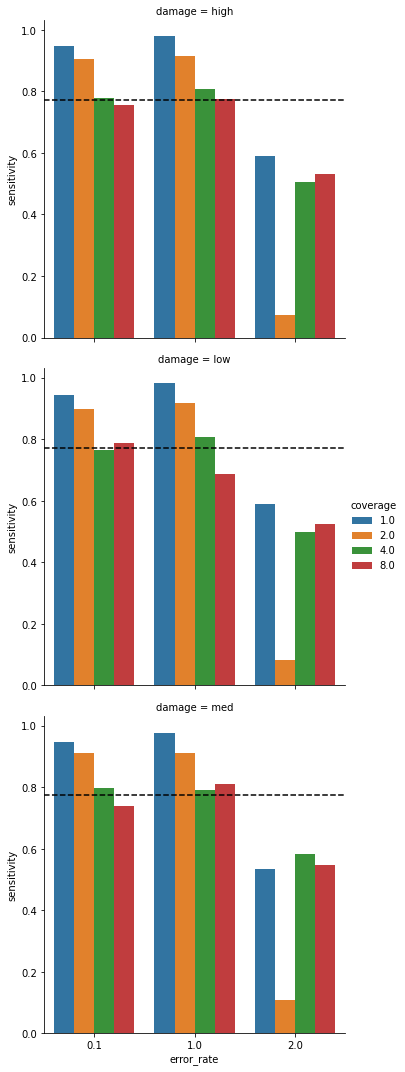

In [24]:
df_sens = dfres.groupby(["damage", "error_rate", "coverage"]).apply(sensitivity).to_frame("sensitivity").reset_index()

chart = sns.catplot(data=df_sens, y="sensitivity", x="error_rate", hue="coverage", kind="bar",row='damage', legend_out=True)
chart.axes[0][0].axhline(y=sensitivity(dforirignal), ls='--', c='black')
chart.axes[1][0].axhline(y=sensitivity(dforirignal), ls='--', c='black')
chart.axes[2][0].axhline(y=sensitivity(dforirignal), ls='--', c='black')
plt.savefig('/home/mathieu/Bureau/fig/newSens.png', transparent=False)

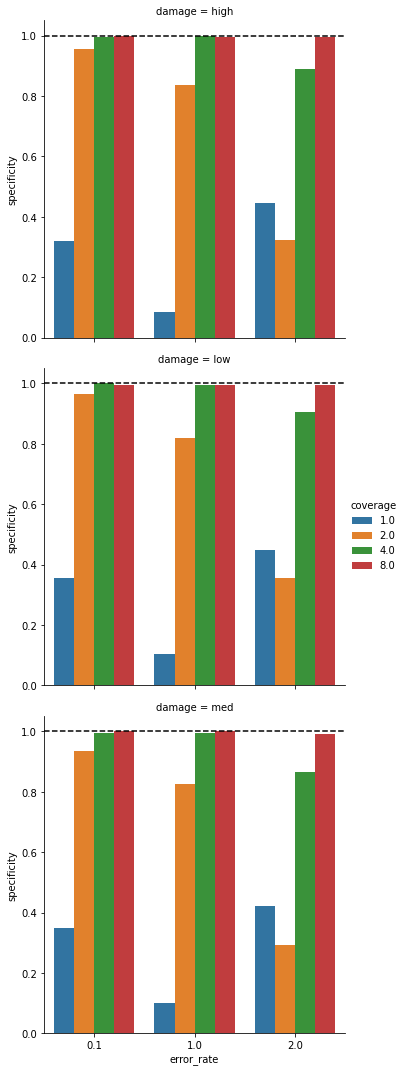

In [25]:
df_spe = dfres.groupby(["damage", "error_rate", "coverage"]).apply(specificity).to_frame("specificity").reset_index()
chart = sns.catplot(data=df_spe, y="specificity", x="error_rate", hue="coverage", row="damage", kind="bar", legend_out=True)
chart.axes[0][0].axhline(y=specificity(dforirignal), ls='--', c='black')
chart.axes[1][0].axhline(y=specificity(dforirignal), ls='--', c='black')
chart.axes[2][0].axhline(y=specificity(dforirignal), ls='--', c='black')
plt.savefig('/home/mathieu/Bureau/fig/newSpe.png', transparent=False)